---
layout: page
title: Correlação
nav_order: 24
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/24-Correlacao.ipynb)

# Tópico 24 – Correlação
{: .no_toc .mb-2 }

Ao finalizarmos nossa introdução às noções básicas de Inferência Estatística, agora discutiremos um tópico crucial em Ciência de Dados: o de como medir associação entre duas (ou mais) variáveis, e como utilizar a natureza dessa associação para prever os valores de uma variável como função da outra. Nesse contexto, introduziremos nessa aula o conceito de correlação, uma das métricas mais utilizadas (e mais interpretáveis) para medir a associação entre duas variáveis.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Definir o que é uma associação entre duas ou mais variáveis.
1. Discutir a importância das associações lineares.
1. Introduzir o conceito de correlação.

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (10, 5)

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

import warnings
warnings.filterwarnings('ignore')

# Demonstration code
from IPython.display import display
import ipywidgets as widgets

def r_scatter(r):
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r * x + (np.sqrt(1 - r ** 2)) * z
    plt.scatter(x, y)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(f'$r={r}$')
    
def show_scatter_grid():
    plt.subplots(1, 4, figsize=(10, 2))
    for i, r in enumerate([-1, -2/3, -1/3, 0]):
        plt.subplot(1, 4, i+1)
        r_scatter(r)
        plt.title(f'r = {np.round(r, 2)}')
    plt.show()
    plt.subplots(1, 4, figsize=(10, 2))
    for i, r in enumerate([1, 2/3, 1/3]):
        plt.subplot(1, 4, i+1)
        r_scatter(r)
        plt.title(f'$r = {np.round(r, 2)}$')
    plt.subplot(1, 4, 4)
    plt.axis('off')
    plt.show()

## Recapitulando: Inferência Estatística

### O que aprendemos até agora

Até agora, na segunda parte do curso focamos em **Inferência Estatística**, que aqui definimos como o ato de tirar conclusões sobre uma população com base em uma amostra.

- Para obter uma **estimativa pontual** de um parâmetro populacional, utilizamos uma estatística apropriada.
    - Para quantificar a incerteza sobre nossa estimativa, utilizamos bootstrap ou alguma teoria específica (por exemplo o TCL para a média amostral) para construir **Intervalos de Confiança**, que são **estimativas intervalares** para o nosso parâmetro. 

- Para testar se uma amostra vem de uma população específica conhecida, ou se algum parâmetro populacional de interesse é igual a um certo valor, realizamos **Testes de Hipóteses**.
    - Existe uma relação intrínseca entre Testes de Hipóteses e Intervalos de Confiança, e esses últimos também podem ser utilizados para verificar se o valor hipotetizado para o parâmetro de interesse é compatível com nossa amostra.

### O que vamos ver adiante

- Até o final do curso, nosso foco agora será em realizar **previsões**.
    - Isto é, com base em uma amostra, podemos dizer algo sobre a parte da população que **não está na amostra**?

- Mais especificamente, vamos nos ater à **regressão linear**, uma técnica de predição que tenta encontrar a "melhor relação linear" entre duas ou mais variáveis numéricas.
    - Você fatalmente trabalhará com regressão linear (e não-linear!) em muitos outros cursos. Essa é uma das ferramentas mais úteis em Ciência de Dados.

## Associação

### Previsão

- Suponha que tenhamos um conjunto de dados com no mínimo duas variáveis numéricas.

- Nesse contexto, estamos interessados em **prever** uma variável com base nos valores de uma outra (ou de outras).
- Por exemplo:
    - Com base no meu nível educacional, qual seria minha renda?
    - Com base na minha altura, qual seria a altura do meu filho?
    - Com base na minha idade, quantos países (ou continentes) eu já teria visitado? 

- Para fazermos uma "boa previsão", o primeiro passo é identificar padrões comuns às duas variáveis.

- Informalmente, uma medida que quantifica os padrões comuns observados entre duas (ou mais) variáveis é denominada de **medida de associação**.

### Associação

- Um pouco mais formalmente, uma **associação** é qualquer tipo de relação entre duas variáveis que pode ser descrita por uma função.
    - Naturalmente, essa função pode ou não ser linear.

- Uma maneira comum de representarmos uma relação funcional entre duas variáveis é elaborando um gráfico dos seus valores como pontos em um plano Cartesiano.
    - Esse tipo de gráfico é conhecido como **diagrama de dispersão**.

- Se duas variáveis tem associação positiva ↗️, então à medida que uma aumenta, a outra tende a aumentar.

- Se duas variáveis tem associação negativa ↘️, então à medida que uma aumenta, a outra tende a diminuir. 

- Em geral, se duas variáveis estão associadas, podemos utilizar a natureza dessa associação para predizer uma baseada no valor da outra.

### Exemplo: carros híbridos 🚗

Nosso [conjunto de dados](https://search.r-project.org/CRAN/refmans/DJL/html/dataset.hev.2013.html) contém diferentes informações sobre vários carros híbridos, cujos anos do modelo variam de 1997 a 2013.

In [2]:
hybrid = pd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/20-Correlacao/data/hybrid.csv')
hybrid

,vehicle,year,price,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact


### `'price'` vs. `'acceleration'`

Existe alguma associação entre essas duas variáveis? Se sim, qual é a natureza dessa associação?

(Nota: Ao analisar um diagrama de dispersão, frequentemente nos referimos à relação entre as variáveis como "$y$ em função de $x$".)

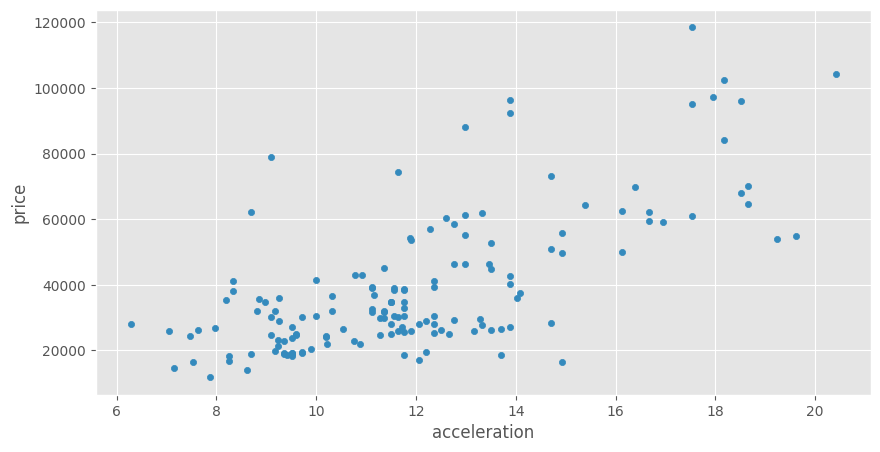

In [3]:
hybrid.plot(kind='scatter', x='acceleration', y='price');

A aceleração aqui é medida em quilômetros por hora por segundo, e logo acelerações maiores são sinônimos de carros mais rápidos!

### `'price'` vs. `'mpg'`

Existe associação entre essas variáveis? Se sim, de qual tipo?

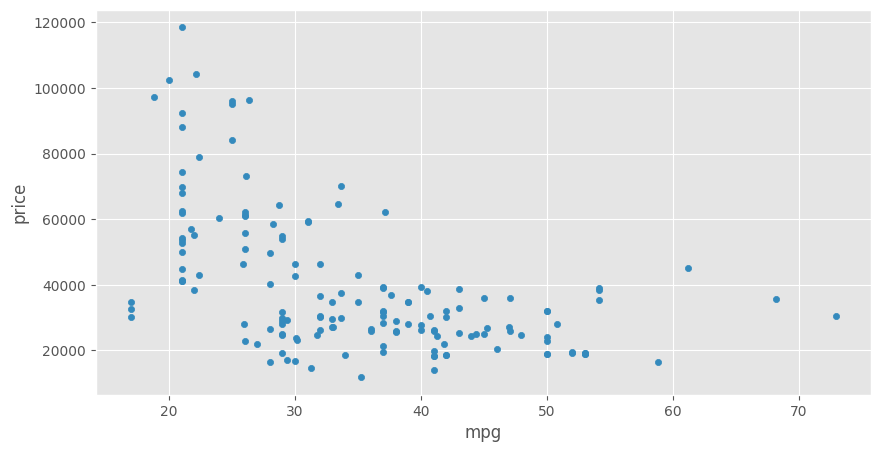

In [4]:
hybrid.plot(kind='scatter', x='mpg', y='price');

- Existe uma associação negativa: carros com maior rendimento tendem a ser mais baratos.

- Porém, a associação _não parece ser linear_! 
    - Uma função que poderia descrever essa associação é $y \approx \frac{1}{x}$.   

### Explorando os dados 

<Axes: xlabel='mpg', ylabel='price'>

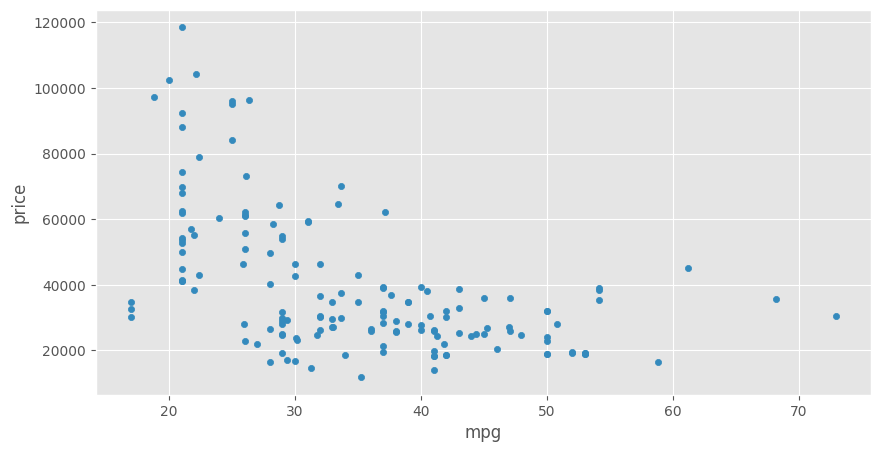

In [5]:
hybrid.plot.scatter(x='mpg', y='price')

### Medindo uma associação

- A partir do diagrama de dispersão, podemos ter uma boa ideia se duas variáveis estão associadas, e se essa associação é positiva ou negativa.

- Porém, embora os diagramas de dispersão sejam ferramentas muito úteis, um diagrama de dispersão é no fundo uma _ferramenta gráfica/visual_.

- Para termos uma noção _quantitativa_ da associação entre duas variáveis, precisamos de uma _medida de associação_.

## Correlação

### Coeficiente de Correlação (de Pearson)

- O coeficiente de correlação $r$ entre duas variáveis $X$ e $Y$ mede a **força da associação linear entre $X$ e $Y$**.

- De maneira informal, $r$ mede o quão "próximos" os pontos de $X$ e $Y$ estão ao redor de uma reta.

- $r$ é igual a: 
    - **média** dos 
    - **produtos** entre $X$ e $Y$,
    - quando $X$ e $Y$ são ambas expressas em **unidades padronizadas**.

- $r$ está sempre entre -1 e 1.

- Antes de definir $r$ formalmente, vamos analisar alguns exemplos para trabalharmos um pouco nossa intuição.

### Exemplo: Diagramas de dispersão para diferentes valores de $r$

Considere os seguintes diagramas de dispersão:

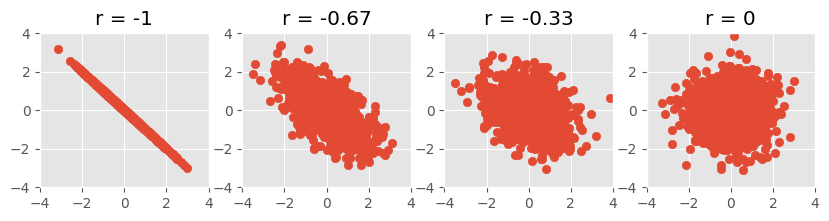

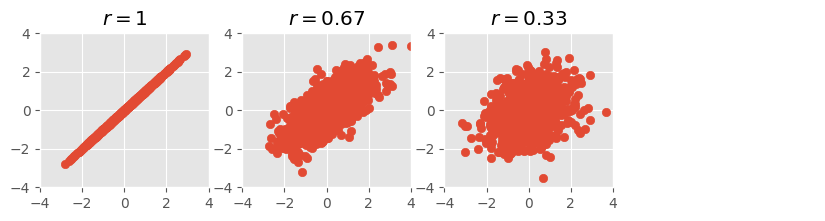

In [6]:
show_scatter_grid()

- O sinal de $r$ (negativo ou positivo) define a natureza da associação (linear) entre $X$ e $Y$, isto é:
    - se $r < 0$, então $X$ e $Y$ estão negativamente associadas (e logo **negativamente correlacionadas**);
    - se $r > 0$, então $X$ e $Y$ estão positivamente associadas (e logo **positivamente correlacionadas**);
    - se $r = 0$, não existe associação (linear) entre $X$ e $Y$ (e logo dizemos que $X$ e $Y$ são **não correlacionadas**).

- Quando $r = 1$, dizemos que existe uma **correlação perfeita** entre $X$ e $Y$, ou que a relação entre $X$ e $Y$ é **perfeitamente linear**.
    - Analogamente, o mesmo vale para $r = -1$, mas nesse caso dizemos que a correlação entre $X$ e $Y$ é **perfeitamente negativa**.

Para visualizar outros exemplos de diagramas de dispersão para mais valores de $r$, podemos utilizar o widget abaixo.

In [7]:
widgets.interact(r_scatter, r=(-1, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='r', max=1.0, min=-1.0, step=0.05), Output()), _dom_c…

### Definição formal

- Para uma amostra de tamanho $n$ de duas variáveis $\mathbf{X} := X_1, \ldots, X_n$ e $\mathbf{Y} := Y_1, \ldots, Y_n$, o **coeficiente de correlação amostral** $r$ é definido por

\begin{equation*}
    r := \frac{\sum^n_{i=1} (X_i - \bar{X}) (Y_i - \bar{Y})}{\sqrt{\sum^n_{i=1} (X_i - \bar{X})^2} \sqrt{\sum^n_{i=1} (Y_i - \bar{Y})^2}} = \frac{\sum^n_{i=1} (X_i - \bar{X}) (Y_i - \bar{Y}) / n}{\sqrt{S^2_x} \sqrt{S^2_y}} = \frac{\sum^n_{i=1} (X_i - \bar{X}) (Y_i - \bar{Y}) / n}{S_x S_y},
\end{equation*}

onde $\bar{X}$ e $S_x$ são a média amostral e o desvio padrão amostral de $\mathbf{X}$ e $\bar{Y}$ e $S_y$ são a média amostral e o desvio padrão amostral de $\mathbf{Y}$, respectivamente.

- Note que nessa definição acima explicitamos o fato de $r$ ser uma correlação **amostral** pois a correlação é apenas um parâmetro.
    - Dessa forma, para uma certa população, existe também a **correlação populacional**, $\rho$.
    - Como na prática não sabemos $\rho$, utilizamos $r$ (que é uma estatística) como uma estimativa de $\rho$, assim como fazemos com qualquer parâmetro de interesse.

- <u>Nota histórica</u>:  O coeficiente de correlação $r$ é comumente denominado de coeficiente de correlação _de Pearson_, porque foi amplamente estudado por Karl Pearson por volta do ano 1895, com base em algumas das ideias que Francis Galton desenvolvera por volta do ano 1880.
    - Você verá outros coeficientes de correlação e outras medidas de associação em outros cursos, mas o coeficiente de correlação de Pearson é sem dúvida o mais popular! 

### De volta à definição intuitiva

- Voltando à definição anterior e intuitiva, em que $r$ é a "média dos produtos entre $X$ e $Y$, quando $X$ e $Y$ são ambas expressas em unidades padronizadas", primeiramente note que as unidades padronizadas correspondentes à cada $X_i$ e $Y_i$ são dadas por, respectivamente,

\begin{align*}
    X_{i \: \text{(su)}} &:= \frac{X_i - \bar{X}}{S_x}, & & & Y_{i \: \text{(su)}} &:= \frac{Y_i - \bar{Y}}{S_y}.
\end{align*}

- Dessa forma, podemos reescrever então

\begin{equation*}
    r = \frac{\sum^n_{i=1} (X_i - \bar{X}) (Y_i - \bar{Y}) / n}{S_x S_y} = \frac{1}{n} \sum^n_{i=1} \frac{(X_i - \bar{X})}{S_x} \frac{(Y_i - \bar{Y})}{S_y} = \frac{1}{n} \sum^n_{i=1} X_{i \: \text{(su)}} Y_{i \: \text{(su)}},
\end{equation*}

e que logo corresponde à definição intuitiva.

### Interpretando $r$

- Como mencionado anteriormente, o coeficiente de correlação $r$ mede a **força da associação linear entre $X$ e $Y$**.

- Dessa forma, se $r \neq 0$, dizemos que $X$ e $Y$ são _correlacionadas_, e logo existe algum "grau" de _associação linear_ entre $X$ e $Y$.

- O "grau" de associação linear entre $X$ e $Y$ é exatamente dado pela **magnitude** da correlação entre $X$ e $Y$, isto é, por $|r$.
    - Vimos acima que o **sinal** de $r$ vai medir a **direção** da associação entre $X$ e $Y$, mas sua **força** é medida por $|r|$.

- Voltando ao nosso objetivo original (de prever de $Y$ como função de $X$), podemos dizer que $r$ **quantifica o quão bem podemos prever (de maneira linear) uma variável aravés dos valores da outra**.
    - Se $r \approx 1$ ou $r \approx -1$, podemos fazer uma "boa previsão" de $Y$ como função linear de $X$.
    - Se $r \approx 0$, não podemos fazer uma boa previsão de $Y$ como função linear de $X$.

- Finalmente, note que o coeficiente de correlação é _simétrico_, isto é, a correlação entre $X$ e $Y$ é igual à correlação entre $Y$ e $X$.
    - Isso é intuitivo e relativamente fácil de visualizar, pois na fórmula de $r$ temos $X_{i \: \text{(su)}} Y_{i \: \text{(su)}} = Y_{i \: \text{(su)}} X_{i \: \text{(su)}}$ para cada $i$.

- <u>Nota técnica</u>: Embora tenhamos assumido até agora que isso seja verdade, é possível provar de fato que $r$ está sempre entre $-1$ and $1$.

In [8]:
# Once again, run this cell and play with the slider that appears!
widgets.interact(r_scatter, r=(-1, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='r', max=1.0, min=-1.0, step=0.05), Output()), _dom_c…

### Calculando $r$ no Python

Vamos agora calcular o valor de $r$ para os dois diagramas de dispersão que fizemos acima: `'price'` vs. `'acceleration'` e `'price'` vs. `'mpg'`.

Primeiramente, vamos definir uma função que expressa $X$ ou $Y$ (colunas de um `DataFrame`) em unidades padronizadas:

In [9]:
def standard_units(col):
    return (col - col.mean()) / np.std(col)

Agora, vamos definir uma função que calcula a correlação $r$ a partir das unidades padronizadas:

In [10]:
def calculate_r(df, x, y):
    '''Returns the average value of the product of x and y, 
       when both are measured in standard units.'''
    x_su = standard_units(df.get(x))
    y_su = standard_units(df.get(y))
    return (x_su * y_su).mean()

### `'price'` vs. `'acceleration'`

Voltando aos exemplos anteriores, primeiro vamos calcular a correlação $r$ entre `'acceleration'` e `'price'`:

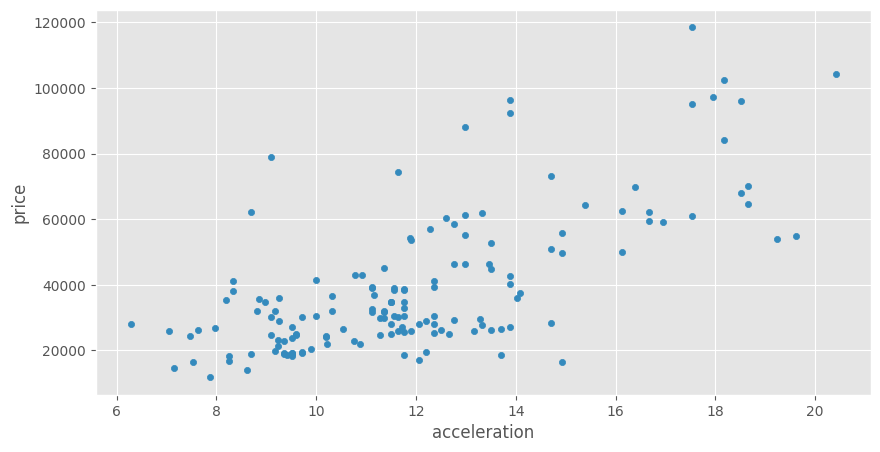

In [11]:
hybrid.plot(kind='scatter', x='acceleration', y='price');

In [12]:
calculate_r(hybrid, 'acceleration', 'price')

0.6955778996913978

Como $r > 0$, a associação entre `'acceleration'` e `'price'` é positiva.

### `'price'` vs. `'mpg'`

Agora, vamos calcular a correlação entre `'mpg'` e `'price'`:

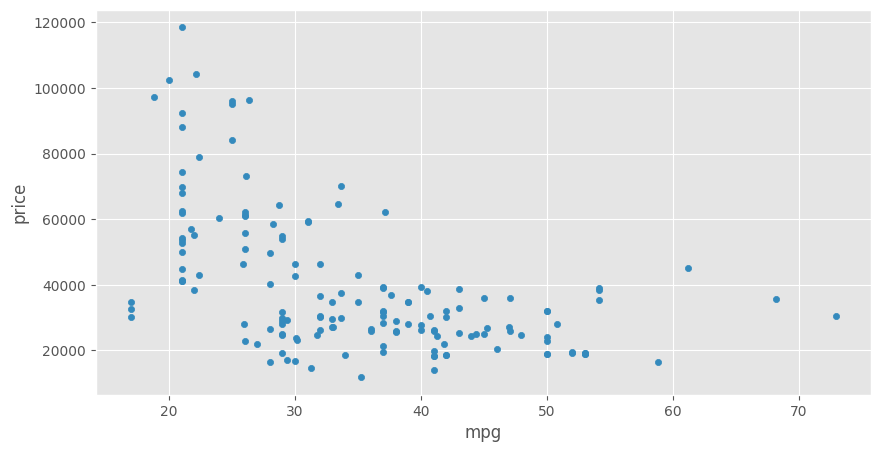

In [13]:
hybrid.plot(kind='scatter', x='mpg', y='price');

In [14]:
calculate_r(hybrid, 'mpg', 'price')

-0.5318263633683786

Aqui, $r < 0$, e logo a associação entre `'mpg'` and `'price'` é negativa.

Note que, como aqui $|r| \simeq 0.53$ e no exemplo anterior $|r| \simeq 0.70$, a magnitude da correlação entre `'mpg'` e `'price'` é menor do que a magnitude da correlação entre `'acceleration`' e `'price'`.

Em outras palavras, a relação entre `'mpg'` e `'price'` é "menos linear" do que aquela entre `'acceleration`' e `'price'`.

### Transformações lineares

- Para entender melhor porque utilizamos unidades padronizadas na correlação $r$, precisamos do conceito de **transformações lineares**.

- Formalmente, dada uma amostra $\mathbf{X} := (X_1, \ldots, X_n)$ de uma variável $X$, uma **transformação linear** de $X$ é definida por

\begin{equation*}
    aX_i + b
\end{equation*}

para todo $i = 1, \ldots, n$, $a \in \mathbb{R}$ e $b \in \mathbb{R}$.

- Uma transformação linear claramente modifica a **locação** e a **escala** de $X$, mas também pode modificar as **unidades de medida de $X$**.

- Por exemplo, a fórmula de conversão de graus Celsius para graus Fahrenheit é uma transformação linear com $a = 9/5$ e $b = 32$, pois
    
$$X^\text{Fahrenheit}_i = \frac{9}{5} X^\text{Celsius}_i + 32.$$

- Analogamente, podemos converter uma quantidade qualquer de reais $X^\text{BRL}_i$ em dólares (cotação do dia 23/07/24) tomando $a = 5.58$ e $b = 0$:

$$X^\text{USD}_i = 5.58 X^\text{BRL}_i \:\:\: 😀$$

... e converter de volta (de dólares para reais) tomando $a = 1/5.58 = 0.18$ e $b = 0$:

$$X^\text{BRL}_i = 0.18 X^\text{USD}_i \:\:\: 😢$$

### E porque então utilizamos variáveis padronizadas no cálculo de $r$?

- Voltando à nossa pergunta original, primeiramente note que **a padronização é uma transformação linear**!
    - Como $X_{i \: \text{(su)}} = (X_i - \bar{X})/S_x = X_i/S_x - \bar{X}/S_x$, para ver isso basta tomar $a = 1/S_x$ e $b = - \bar{X}/S_x$ na transformação linear acima.

- Dessa forma, como a padronização elimina a influência da unidade de medida sobre $X_i$ (uma vez que $X_{i \: \text{(su)}}$ está expressa em unidades padronizadas), **utilizamos variáveis padronizadas para que o coeficiente de correlação $r$ não seja influenciado pelas escalas/unidades de medida das nossas variáveis**.
    - Dizemos então que $r$ é **invariante à escala**.

- É ainda mais correto dizer que $r$ _invariante à transformações lineares_, pois a padronização elimina qualquer influência de locação e escala, de forma que $X_{i \: \text{(su)}}$ é _idêntica_ se for calculada com base nos valores de $X_i$ ou em $aX_i + b$. 

- Similarmente, quando aplicamos uma transformação linear às variáveis em um diagrama de dispersão, **mudamos apenas os eixos $x$ e $y$**, isto é, as unidades de medida das variáveis representadas no diagrama.
    - Como as transformações lineares não alteram a correlação entre $X$ e $Y$, a associação entre elas representada no diagrama de dispersão também não se altera!

- Voltando ao nosso exemplo original dos carros, note que o diagrama de dispersão não se altera ao expressarmos os preços em _ienes_ ao invés de _dólares_, e/ou a autonomia em _quilômetros por galão_ ao invés de _milhas por galão_.
    - Conforme discutido acima, apenas _os eixos_ são alterados por essas conversões.

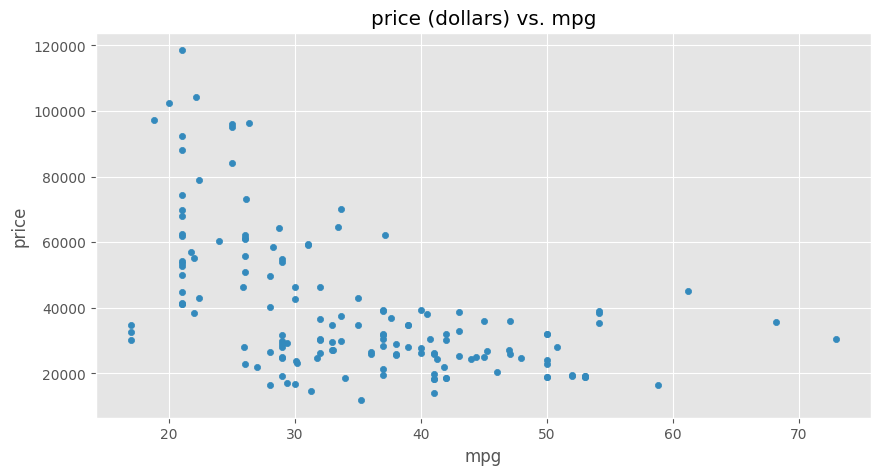

In [15]:
hybrid.plot(kind='scatter', x='mpg', y='price', title='price (dollars) vs. mpg');

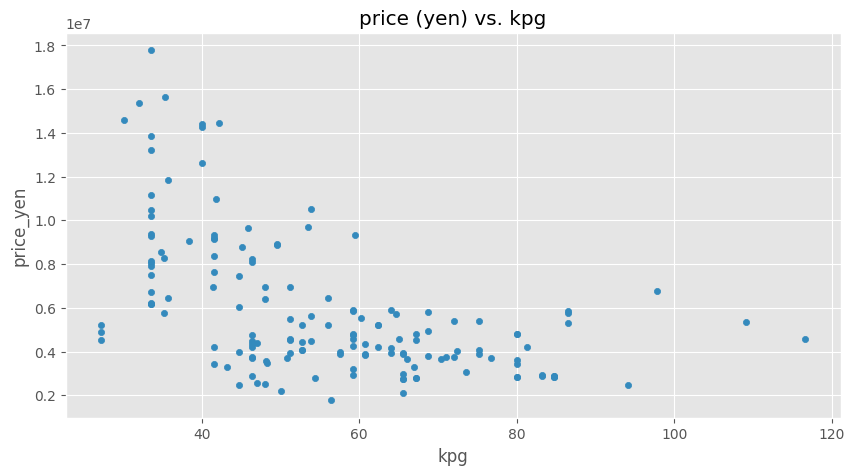

In [16]:
hybrid.assign(
    price_yen=hybrid.get('price') * 149.99, # The current USD to Japanese Yen exchange rate.
    kpg=hybrid.get('mpg') * 1.6             # 1 mile is 1.6 kilometers.
).plot(kind='scatter', x='kpg', y='price_yen', title='price (yen) vs. kpg');

- Reiterando sobre o ponto anterior, como uma alteração nas unidades de medida não altera a associação linear entre as variáveis, a força de associação linear representada no diagrama de dispersão – e que logo corresponde à $r$ – também não se altera.
    - Como sempre utilizamos unidades padronizadas para calcular $r$, garantimos que o seu valor – e sua interpretação – seja sempre o mesmo.

- No exemplo em questão, a correlação entre os preços em dólares e a autonomia em milhas por galão e a correlação entre os preços em ienes e a autonomia em quilômetros por galão **é a mesma**.

### Teste Rápido ✅ 

Analise o diagrama de dispersão a seguir. O que você pode dizer sobre a relação entre $y$ e $x$?

- A. $x$ e $y$ são associadas e correlacionadas.
- B. $x$ e $y$ são associadas, mas não correlacionadas.
- C. $x$ e $y$ não são associadas, mas são correlacionadas.
- D. $x$ e $y$ não são associadas e nem são correlacionadas.

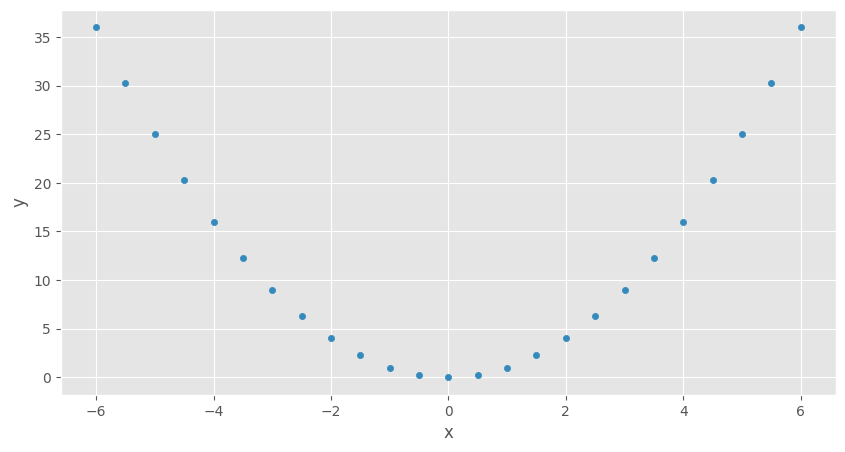

In [17]:
x2 = pd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5), 
    y=np.arange(-6, 6.1, 0.5) ** 2
)
x2.plot(kind='scatter', x='x', y='y');

## Resumo e próxima aula

### Resumo

- O coeficiente de correlação $r$ mede a **força de associação linear** entre $X$ e $Y$.
    - Sempre temos $r \in [-1, 1]$.
- A **magnitude** da associação linear entre $X$ e $Y$ é dada por $|r|$.
    - Analogamente, o **sinal** de $r$ nos dá a **direção da associação** entre $X$ e $Y$.
    - Se $r < 0$, $X$ e $Y$ são **negativamente** associadas;
    - Se $r > 0$, $X$ e $Y$ são **positivamente** associadas.
- A correlação é simétrica e **invariante sob transformações lineares**.
    - Dessa forma, o valor de $r$ é o mesmo **qualquer que sejam** as unidades de medida de $X$ e $Y$.

### Próxima aula

Introduziremos uma das técnicas mais úteis e populares para realizarmos previsões com base na correlação entre duas variáveis: a **regressão linear**.